# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

In [107]:
#!pip install tensorflow
#!pip install gensim
#!pip install transformers
#!pip install sentencepiece

     ---------------------------------------- 1.1/1.1 MB 704.9 kB/s eta 0:00:00


# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [56]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [57]:
# Fichier des tweets à récupérer sur : https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

path = 'Flipkart/' # à adapter = répertoire de stockage du dataset
data_T0 = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
print(data_T0.shape)

(1050, 15)


In [58]:
data_T0.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [59]:
data_T0['product_category_tree1']=data_T0['product_category_tree'].str.replace('[', '').str.replace('"', '')
#Splitting category column 
data_T0['main_category']=data_T0['product_category_tree1'].str.split('>>', expand=True)[0]
data_T0['main_category'].value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: main_category, dtype: int64

In [70]:
print("Number of main category ",data_T0['main_category'].nunique())

Number of main category  7


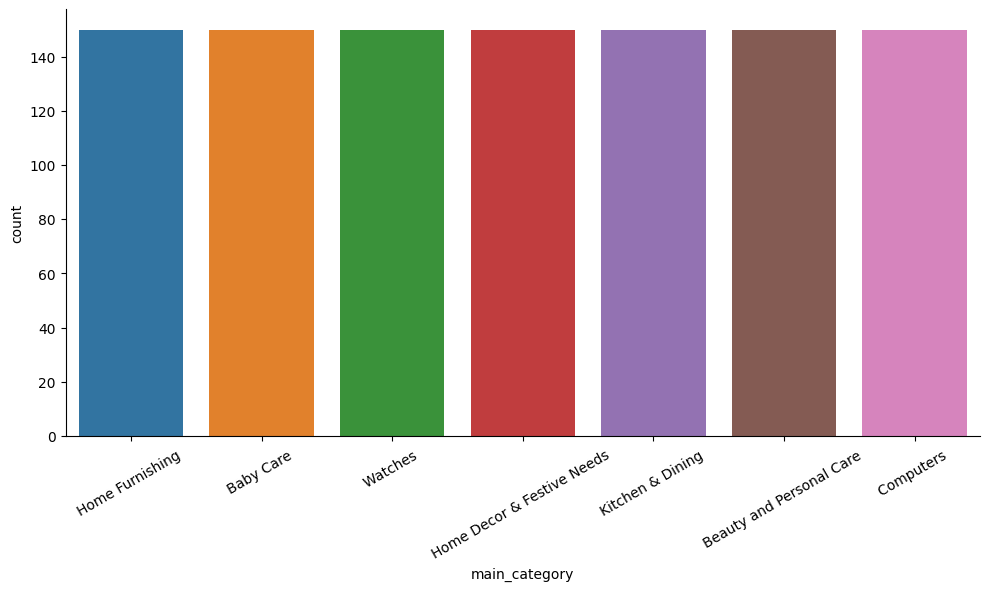

In [122]:

g = sns.catplot(data=data_T0, x="main_category",
                kind="count", height=5, aspect=2)
g.set_xticklabels(rotation=30)

In [131]:
def second_category(value):
    try:
        return value.split('>>')[1]
    except IndexError:
        return 'None'
def third_category(value):
    try:
        return value.split('>>')[2]
    except IndexError:
        return 'None'

In [76]:
data_T0['sub_category']=data_T0['product_category_tree1'].apply(second_category)
data_T0['sub-sub_category']=data_T0['product_category_tree1'].apply(third_category)
print("Number of sub category ",data_T0['sub_category'].nunique())

Number of sub category  63


In [77]:
print("Number of sub category ",data_T0['sub-sub_category'].nunique())

Number of sub category  247


In [63]:
data_T0.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications',
       'product_category_tree1', 'main_category', 'sub_category',
       'sub-sub_category'],
      dtype='object')

In [64]:
data_T0[['product_name','product_category_tree1','main_category','sub_category']].head()


,product_name,product_category_tree1,main_category,sub_category
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing >> Curtains & Accessories >> C...,Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing >> Bed Linen >> Bedsheets >> S...,Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing >> Bed Linen >> Bedsheets >> J...,Home Furnishing,Bed Linen


In [78]:
cols=['description','image','main_category']
data1=data_T0[cols]
data1.head()

,description,image,main_category
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


<AxesSubplot: >

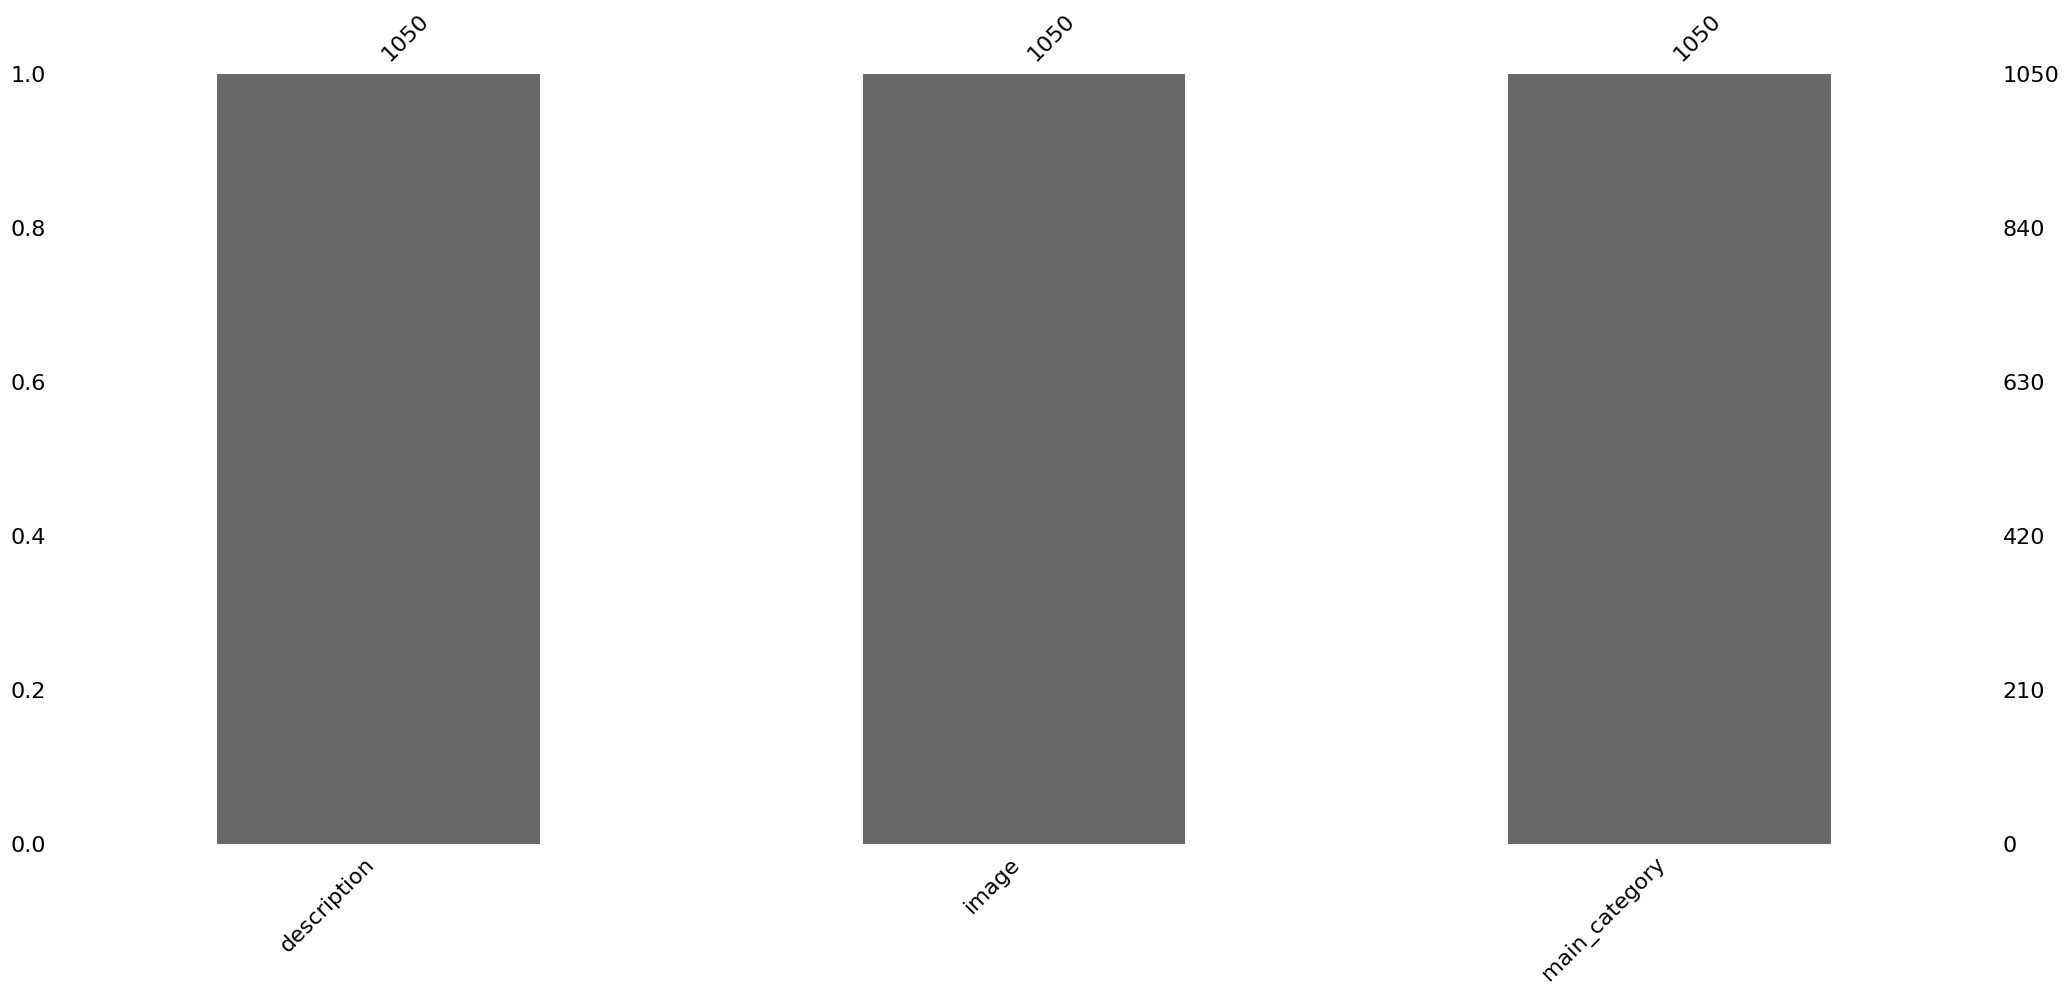

In [79]:
msno.bar(data1)

In [67]:
data1=data1.dropna(axis=0)
data1.shape

(1050, 3)

In [80]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


In [81]:
#Préparartion du texte pour le bag of words
data1['sentence_bow'] = data1['description'].apply(lambda x : transform_bow_fct(x))#tokonization+lower case+stop words
data1['sentence_bow_lem'] = data1['description'].apply(lambda x : transform_bow_lem_fct(x))#tokonization+lower case+stop words+lemmatization
#préparation du texte pour le Deep learning
data1['sentence_dl'] = data1['description'].apply(lambda x : transform_dl_fct(x))#tokonization+lower case
data1.shape


(1050, 6)

In [82]:
data1.head(3)

,description,image,main_category,sentence_bow,sentence_bow_lem,sentence_dl
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...


In [83]:
data1.to_csv("data_product.csv",index=False)

# Préparation commune des traitements

In [15]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [84]:
data_T = pd.read_csv("data_product.csv")
print(data_T.shape)

(1050, 6)


In [85]:
l_cat = list(set(data_T['main_category']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['main_category'])) for i in range(len(data_T))]

catégories :  ['Watches ', 'Baby Care ', 'Computers ', 'Home Furnishing ', 'Beauty and Personal Care ', 'Kitchen & Dining ', 'Home Decor & Festive Needs ']


In [89]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  379
max length dl :  632


In [90]:
data_T.head(2)

,description,image,main_category,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_dl
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,156,248
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,63,84


## Fonctions communes

In [132]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie principale")
    plt.title('Représentation des produits par  catégories principales réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [92]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Convert a collection of text documents to a matrix of token counts.
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)#max_df:maximum document frequency.
#Convert a collection of raw documents to a matrix of TF-IDF features
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])
# Encode the Document
cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

In [22]:
cv_transform


<1050x5324 sparse matrix of type '<class 'numpy.int64'>'
	with 34179 stored elements in Compressed Sparse Row format>

In [139]:
#print( cvect.get_feature_names())

In [142]:
#collection of words in the sparse matrix.
# Printing the identified Unique words along with their indices
print("Vocabulary when using Countvectorizer: ", cvect.vocabulary_)


Vocabulary when using Countvectorizer:  {'key': 2923, 'feature': 2236, 'elegance': 2046, 'polyester': 3825, 'multicolor': 3376, 'abstract': 754, 'eyelet': 2185, 'door': 1933, 'curtain': 1735, 'floral': 2316, '213': 234, 'height': 2619, 'pack': 3619, 'price': 3898, '899': 692, 'enhances': 2080, 'look': 3098, 'interiors': 2816, '100': 32, 'high': 2635, 'quality': 3989, 'fabric': 2190, 'style': 4718, 'stitch': 4670, 'metal': 3270, 'ring': 4195, 'make': 3171, 'room': 4227, 'environment': 2101, 'romantic': 4224, 'loving': 3121, 'ant': 896, 'wrinkle': 5283, 'anti': 900, 'shrinkage': 4450, 'elegant': 2047, 'apparance': 914, 'home': 2661, 'bright': 1240, 'modernistic': 3320, 'appeal': 916, 'design': 1835, 'surreal': 4782, 'attention': 988, 'sure': 4773, 'steal': 4653, 'heart': 2613, 'contemporary': 1611, 'valance': 5072, 'slide': 4508, 'smoothly': 4534, 'draw': 1944, 'apart': 909, 'thing': 4885, 'morning': 3342, 'welcome': 5209, 'sun': 4746, 'ray': 4046, 'want': 5172, 'wish': 5245, 'good': 249

In [23]:
ctf_transform

<1050x5324 sparse matrix of type '<class 'numpy.float64'>'
	with 34179 stored elements in Compressed Sparse Row format>

In [143]:

print("Vocabulary when using tfidtvectorizer: ", ctf.vocabulary_)

Vocabulary when using tfidtvectorizer:  {'key': 2923, 'feature': 2236, 'elegance': 2046, 'polyester': 3825, 'multicolor': 3376, 'abstract': 754, 'eyelet': 2185, 'door': 1933, 'curtain': 1735, 'floral': 2316, '213': 234, 'height': 2619, 'pack': 3619, 'price': 3898, '899': 692, 'enhances': 2080, 'look': 3098, 'interiors': 2816, '100': 32, 'high': 2635, 'quality': 3989, 'fabric': 2190, 'style': 4718, 'stitch': 4670, 'metal': 3270, 'ring': 4195, 'make': 3171, 'room': 4227, 'environment': 2101, 'romantic': 4224, 'loving': 3121, 'ant': 896, 'wrinkle': 5283, 'anti': 900, 'shrinkage': 4450, 'elegant': 2047, 'apparance': 914, 'home': 2661, 'bright': 1240, 'modernistic': 3320, 'appeal': 916, 'design': 1835, 'surreal': 4782, 'attention': 988, 'sure': 4773, 'steal': 4653, 'heart': 2613, 'contemporary': 1611, 'valance': 5072, 'slide': 4508, 'smoothly': 4534, 'draw': 1944, 'apart': 909, 'thing': 4885, 'morning': 3342, 'welcome': 5209, 'sun': 4746, 'ray': 4046, 'want': 5172, 'wish': 5245, 'good': 249

## Exécution des modèles

In [93]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.3842 time :  8.0

Tf-idf : 
--------
ARI :  0.4282 time :  7.0


## Graphiques

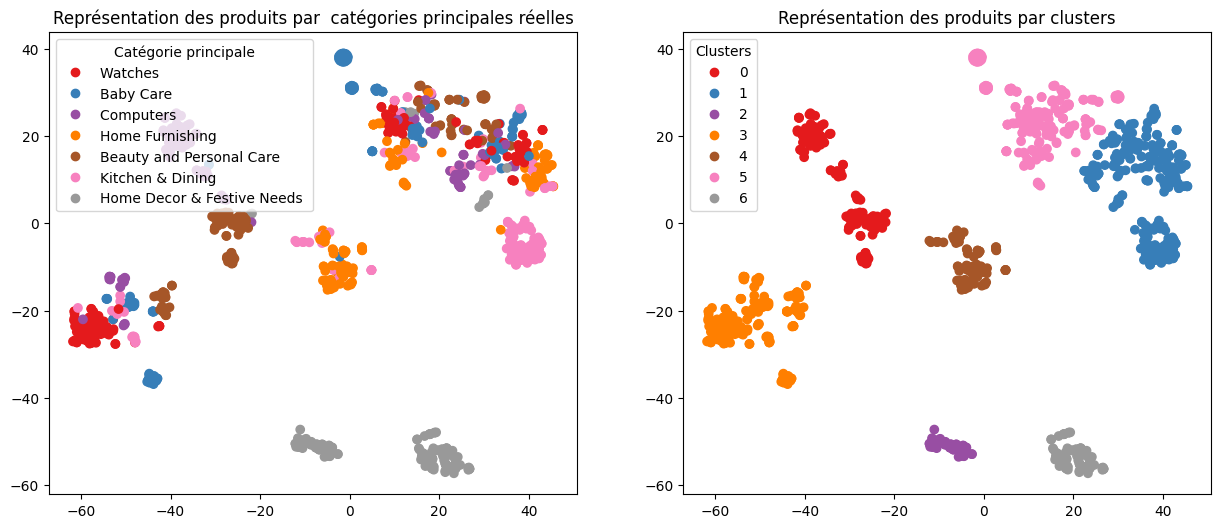

ARI :  0.2163


In [133]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [95]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding.

## Création du modèle Word2Vec

In [96]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
#Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [97]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [98]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [99]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

In [100]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1413900   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [101]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [102]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2163 time :  6.0


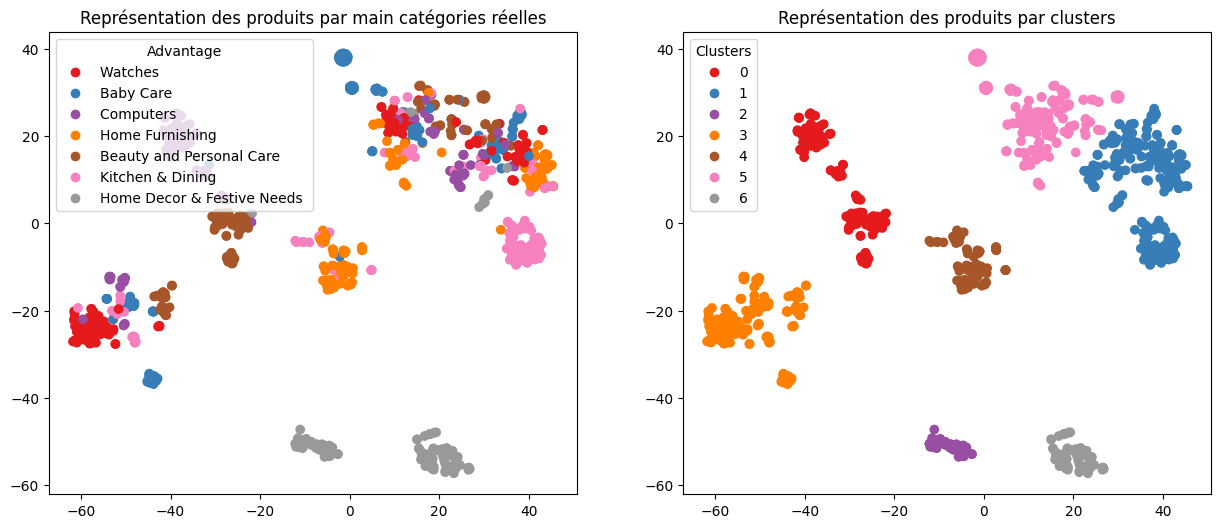

ARI :  0.2163


In [103]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [108]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [109]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
True


## Fonctions communes

In [110]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [111]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

In [17]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  60.0


In [18]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.6177 time :  31.0


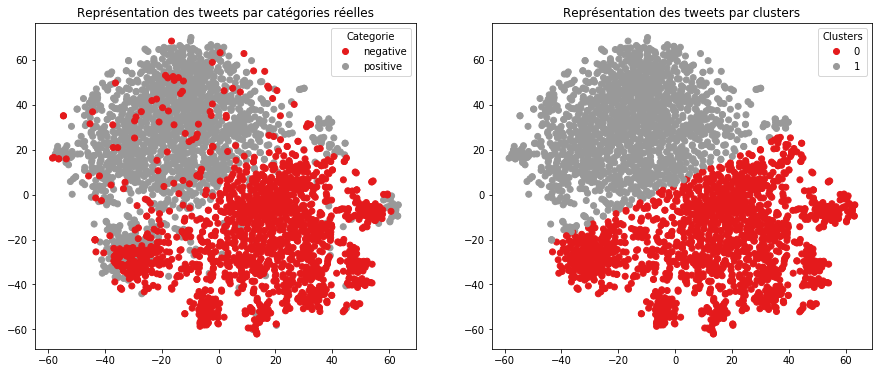

ARI :  0.6177


In [19]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [20]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [21]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  61.0


In [22]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.8836 time :  37.0


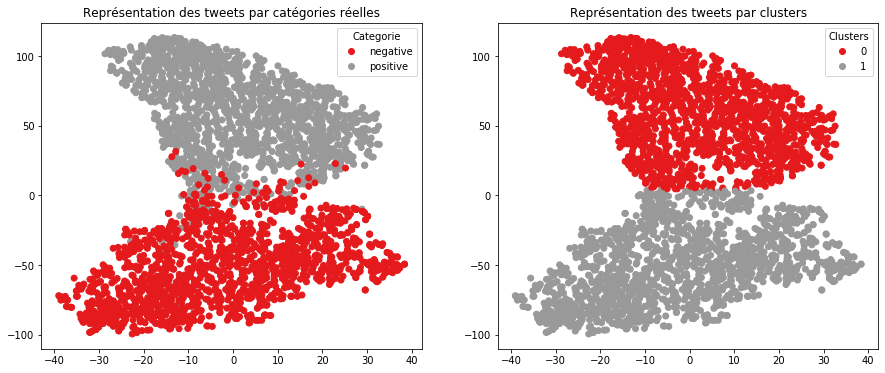

ARI :  0.8836


In [23]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [25]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [26]:
sentences = data_T['sentence_dl'].to_list()

In [27]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  47.0


In [28]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.5805 time :  32.0


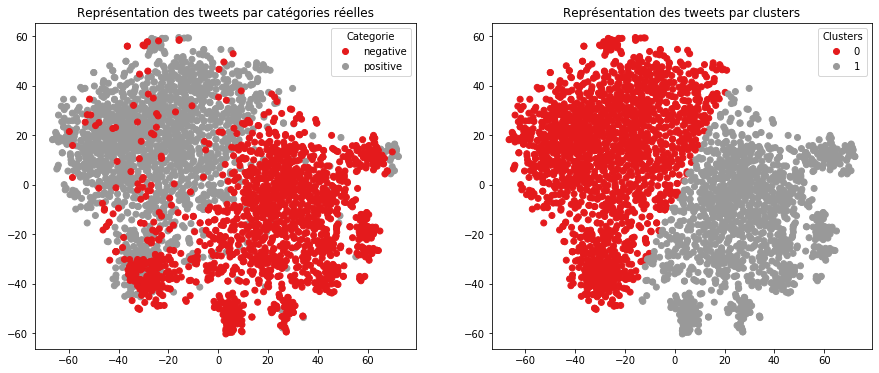

ARI :  0.5805


In [29]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [30]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [31]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.7.0
2.7.0
Num GPUs Available:  1
True


In [32]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [33]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [34]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [35]:
features_USE = feature_USE_fct(sentences, batch_size)

In [36]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.7315 time :  29.0


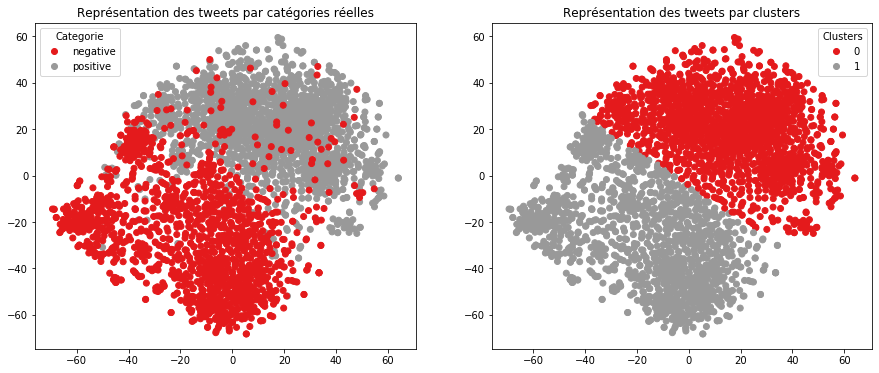

ARI :  0.7315


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)